In [1]:

#载入必要的模组
import numpy as np
import keras
import matplotlib.pyplot as plt

from keras.models import Sequential
from keras.optimizers import Adam
from keras.utils.np_utils import to_categorical


In [2]:
#一种直接从文件夹提取数据的方法
from keras.preprocessing.image import ImageDataGenerator

#做数据增强的指令

train_datagen=ImageDataGenerator(rescale=1./255,
                                rotation_range=45,
                                width_shift_range=0.2,
                                height_shift_range=0.2,
                                shear_range=0.2,
                                zoom_range=0.2,
                                horizontal_flip=True)

#其他进行数据预处理的参数


train_gen=train_datagen.flow_from_directory("data/train",
                                           target_size=(240,240),
                                            batch_size=8,
                                            class_mode="categorical"
                                           )


Found 92 images belonging to 5 classes.


In [3]:
#展示我们的图片
temp=next(train_gen)
print(len(temp))

2


(8, 240, 240, 3)


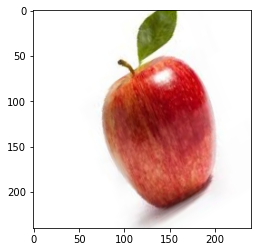

In [5]:
#展示输入图片，注意图片已经被进行了数据增强
print(temp[0].shape)
plt.imshow(temp[0][3,:,:,:])

In [7]:
# 查看数据格式，这一点很重要！！！！自动图像导入
print(np.max(temp[0]))
print(np.min(temp[0]))


1.0
0.0


In [9]:
#展示训练标签，注意已经自动进行了独热编码
print(temp[1].shape)
print(temp[1])

(8, 5)
[[0. 0. 0. 1. 0.]
 [0. 0. 1. 0. 0.]
 [0. 0. 0. 1. 0.]
 [0. 1. 0. 0. 0.]
 [0. 0. 1. 0. 0.]
 [0. 1. 0. 0. 0.]
 [1. 0. 0. 0. 0.]
 [1. 0. 0. 0. 0.]]


In [10]:
 # 输出对应的标签文件夹
print(train_gen.class_indices)




{'紫葡萄': 0, '红苹果': 1, '绿葡萄': 2, '黄苹果': 3, '黄香蕉': 4}


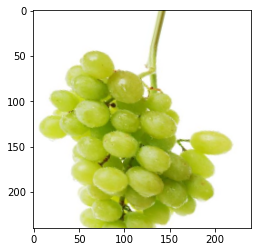

In [12]:
plt.imshow(temp[0][1,:,:,:])

In [13]:
#载入网上预先训练好的模型，注意设置好输入图片大小
VGG=keras.applications.vgg16.VGG16(weights="imagenet",include_top=False,input_shape=[240,240,3])

Instructions for updating:
Colocations handled automatically by placer.


In [16]:
VGG.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0         
__________

In [15]:
#如果网速太慢，用我们为大家提前下载好的模型,记得要放到定义好的路径下
from keras.models import load_model
VGG=load_model("model/VGG_Pretrained.h5")

D:\Users\Anaconda3\envs\env_cv\lib\site-packages\keras\engine\saving.py:292: UserWarning: No training configuration found in save file: the model was *not* compiled. Compile it manually.
  warnings.warn('No training configuration found in save file: '


In [17]:
#加载一些必要的库
from keras.layers import Dense,Flatten

#在模型后面加入分类器，注意输出层神经元个数要和标签一致,一定要加入flatten,不然denselayer无法接受矩阵输入

x=VGG.layers[-1].output
x=Flatten()(x)
x=Dense(64,activation="sigmoid")(x)
predictions=Dense(5,activation="softmax")(x)

model=keras.Model(inputs=VGG.inputs, outputs=predictions)
model.summary()






_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0         
__________

In [24]:
#预先设置好的层将被固定不参与预测，注意可训练参数只有最后的两层之和

for layer in model.layers[:-2]:
    layer.trainable=False

model.summary()



_________________________________________________________________
Layer (type)                 Output Shape              Param #   
input_1 (InputLayer)         (None, 240, 240, 3)       0         
_________________________________________________________________
block1_conv1 (Conv2D)        (None, 240, 240, 64)      1792      
_________________________________________________________________
block1_conv2 (Conv2D)        (None, 240, 240, 64)      36928     
_________________________________________________________________
block1_pool (MaxPooling2D)   (None, 120, 120, 64)      0         
_________________________________________________________________
block2_conv1 (Conv2D)        (None, 120, 120, 128)     73856     
_________________________________________________________________
block2_conv2 (Conv2D)        (None, 120, 120, 128)     147584    
_________________________________________________________________
block2_pool (MaxPooling2D)   (None, 60, 60, 128)       0         
__________

In [25]:

#定义优化器和编译模型
adam=Adam(lr=0.001,beta_1=0.9,beta_2=0.999,epsilon=1e-8)
model.compile(loss="categorical_crossentropy",optimizer=adam,metrics=["accuracy"])


In [26]:
#训练模型
model.fit_generator(train_gen,steps_per_epoch=12,epochs=10)

Instructions for updating:
Use tf.cast instead.
Epoch 1/10
12/12 [==============================] - 51s 4s/step - loss: 1.6271 - acc: 0.3135
Epoch 2/10
12/12 [==============================] - 53s 4s/step - loss: 0.9025 - acc: 0.6785
Epoch 3/10
12/12 [==============================] - 52s 4s/step - loss: 0.7205 - acc: 0.8119
Epoch 4/10
12/12 [==============================] - 52s 4s/step - loss: 0.6501 - acc: 0.7605
Epoch 5/10
12/12 [==============================] - 52s 4s/step - loss: 0.6096 - acc: 0.8344
Epoch 6/10
12/12 [==============================] - 52s 4s/step - loss: 0.5401 - acc: 0.8232
Epoch 7/10
12/12 [==============================] - 53s 4s/step - loss: 0.4596 - acc: 0.8754
Epoch 8/10
12/12 [==============================] - 52s 4s/step - loss: 0.4145 - acc: 0.9373
Epoch 9/10
12/12 [==============================] - 53s 4s/step - loss: 0.3698 - acc: 0.9477
Epoch 10/10
12/12 [==============================] - 53s 4s/step - loss: 0.3599 - acc: 0.9268


(240, 240, 3)


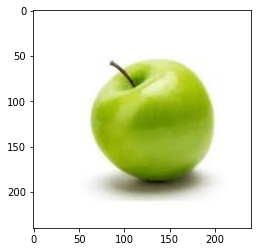

In [35]:
#载入测试数据
import skimage.io as io
import skimage.transform as transform

img=io.imread("data/test/5.jpg")
img=img/255
img=transform.resize(img,output_shape=[240,240])
print(img.shape)
plt.imshow(img)



In [36]:
#结果展示
indices={'紫葡萄': 0, '红苹果': 1, '绿葡萄': 2, '黄苹果': 3, '黄香蕉': 4}

output=model.predict(img.reshape([1,240,240,3]))
print(output)

output_r=np.where(output==np.max(output))
print(np.max(output_r[1]))





[[0.008558   0.37022153 0.01323877 0.5585707  0.04941107]]
3
